In [2]:
%env MKL_THREADING_LAYER=GNU


%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fmin
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

RANDOM_SEED = 20090425

env: MKL_THREADING_LAYER=GNU


In [3]:
from io import StringIO

In [4]:
data_string = """Drugs Score
0 1.17 78.93
1 2.97 58.20
2 3.26 67.47
3 4.69 37.47
4 5.83 45.65
5 6.00 32.92
6 6.42 29.97
"""

In [5]:
lsd_and_math = pd.read_table(StringIO(data_string), sep="\s+", index_col=0)

In [6]:
lsd_and_math

,Drugs,Score
0,1.17,78.93
1,2.97,58.20
2,3.26,67.47
3,4.69,37.47
4,5.83,45.65
5,6.00,32.92
6,6.42,29.97


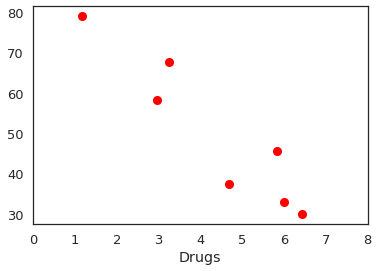

In [7]:
lsd_and_math.plot(x="Drugs", y="Score", style='ro', legend=False, xlim=(0,8))

In [8]:
sum_of_squares = lambda o, x, y: np.sum((y -o[0] - o[0] - o[1]*x) **2)

In [9]:
sum_of_squares([0,1], lsd_and_math.Drugs, lsd_and_math.Score)

17159.344300000001

In [10]:
x, y = lsd_and_math.T.values
b0, b1 = fmin(sum_of_squares, [0,1], args=(x,y))
b0,b1

Optimization terminated successfully.
         Current function value: 253.634103
         Iterations: 94
         Function evaluations: 176


(44.551640552926521, -9.0017424789884437)

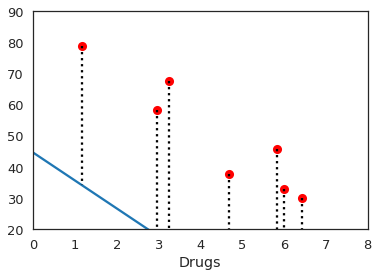

In [12]:
ax = lsd_and_math.plot(x="Drugs", y='Score', style='ro', legend=False, xlim=(0,8), ylim=(20,90))
ax.plot([0,10], [b0, b0+b1*10])
for xi, yi in zip(x,y):
    ax.plot([xi]*2, [yi, b0+b1*xi], 'k:')

In [15]:
sum_of_absval = lambda o,x,y: np.sum(np.abs(y - o[0] - o[1]*x))

Optimization terminated successfully.
         Current function value: 31.752640
         Iterations: 161
         Function evaluations: 316

intercept: 9e+01, slope: -9.3


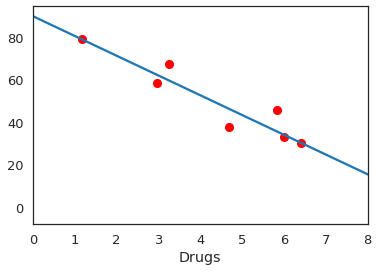

In [17]:
b0, b1 = fmin(sum_of_absval, [0,0], args=(x,y))
print('\nintercept: {0:.2}, slope: {1:.2}'.format(b0,b1))
ax = lsd_and_math.plot(x='Drugs', y='Score', style='ro', legend=False, xlim=(0,8))
ax.plot([0,10], [b0, b0+b1*10])

In [20]:
sum_squares_quad = lambda o,x,y: np.sum((y - o[0] - o[1]*x - o[2]*(x**2)) **2)

Optimization terminated successfully.
         Current function value: 250.773702
         Iterations: 156
         Function evaluations: 278

intercept: 9.2e+01, x: -1.1e+01, x2: 0.24


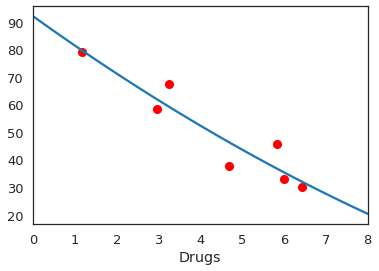

In [22]:
b0,b1,b2 = fmin(sum_squares_quad, [1,1,-1], args=(x,y))
print('\nintercept: {0:.2}, x: {1:.2}, x2: {2:.2}'.format(b0,b1,b2))
ax = lsd_and_math.plot(x='Drugs', y='Score', style='ro', legend=False, xlim=(0,8))
xvals = np.linspace(0,8,100)
ax.plot(xvals, b0 + b1*xvals + b2*(xvals**2))

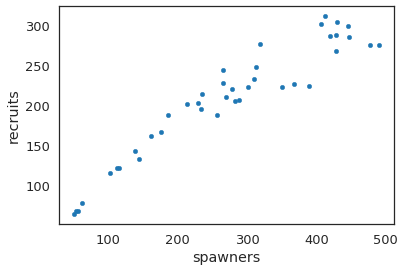

In [23]:
salmon = pd.read_table("salmon.dat", delim_whitespace=True, index_col=0)
salmon.plot.scatter(x='spawners', y='recruits')

(0, 100)

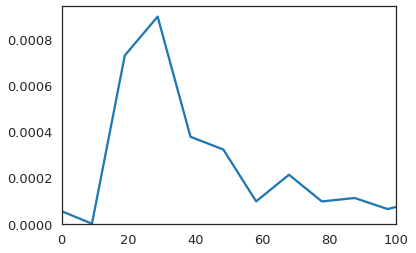

In [24]:
from pymc3 import HalfCauchy

ax = sns.kdeplot(HalfCauchy.dist(1).random(size = 10000), gridsize=2000)
ax.set_xlim(0, 100)

In [25]:
from pymc3 import Normal, Model

with Model() as drugs_model:
    intercept = Normal('intercept', 0, sd = 100)
    slope = Normal('slope', 0, sd=100)
    o = HalfCauchy('o', 1)

In [26]:
with drugs_model:
    u = intercept + slope*x
    score = Normal('score', u, sd=o, observed=y)

In [27]:
from pymc3 import sample

with drugs_model:
    drugs_sample = sample(1000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [o_log__, slope, intercept]
  0%|          | 0/1500 [00:00<?, ?it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '19508' (I am process '19510')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/bmacs/.theano/compiledir_Linux-4.14--amd64-x86_64-with-debian-buster-sid--3.6.4-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '19508' (I am process '19511')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/bmacs/.theano/compiledir_Linux-4.14--amd64-x86_64-with-debian-buster-sid--3.6.4-64/lock_dir
100%|██████████| 1500/1500 [00:08<00:00, 169.48it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '19510' (I am process '19511')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/bmacs/.theano/compiledir_Linux-4.14--amd64-x86_64-w

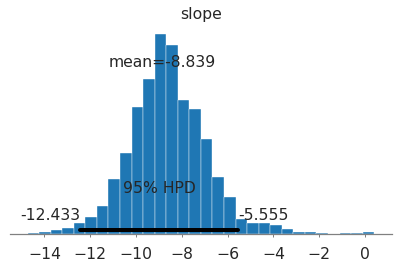

In [28]:
from pymc3 import plot_posterior

plot_posterior(drugs_sample[500:], varnames=['slope'])

In [29]:
from pymc3 import sample_ppc

with drugs_model:
    drugs_ppc = sample_ppc(drugs_sample, 1000)

100%|██████████| 1000/1000 [00:01<00:00, 780.39it/s]


In [30]:
drugs_ppc['score'].shape

(1000, 7)

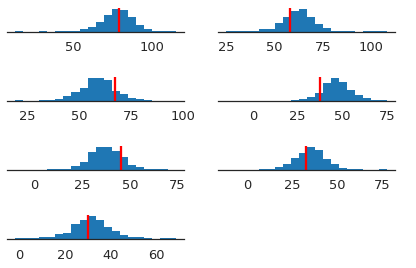

In [33]:
fig, axes = plt.subplots(4,2)
axes_flat = axes.flatten()

for ax, real_data, sim_data in zip(axes_flat[:-1], y, drugs_ppc['score'].T):
    ax.hist(sim_data, bins=20)
    ax.vlines(real_data, *ax.get_ylim(), colors='red')
    ax.set_yticklabels([])
    sns.despine(left=True)
    
axes_flat[-1].axis('off')
plt.tight_layout()

In [34]:
print("Brendan McNamara")

Brendan McNamara
